# Make an SED, showing uncertainties on the disk model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sdf.model
import sdf.www
import requests
import pickle

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# get the results pickle
s = requests.get('http://drgmk.com/sdb/seds/masters/sdb-v2-180701.54+303343.7/public/'
                 'sdb-v2-180701.54+303343.7-mnest/phoenix_m+amsil_r_.pkl')
#                  'sdb-v2-180701.54+303343.7-mnest/phoenix_m+modbb_disk_r_.pkl')
r = pickle.loads(s.content)
        
# refill these, as they're deleted to save space when the pickle is saved
r.models, r.pl_models = sdf.model.get_models(r.obs, r.model_comps)

In [3]:
# create some samples of possible disk models
pos, sampler = sdf.fitting.run_emcee(r, nwalkers=64, nstep=200)

/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [4]:
sampler.get_autocorr_time(c=1)

array([23.82657529, 31.68396355, 68.14232499, 42.96881875, 28.56383131,
       18.21288746, 34.78199441, 32.80277569])

<IPython.core.display.Javascript object>


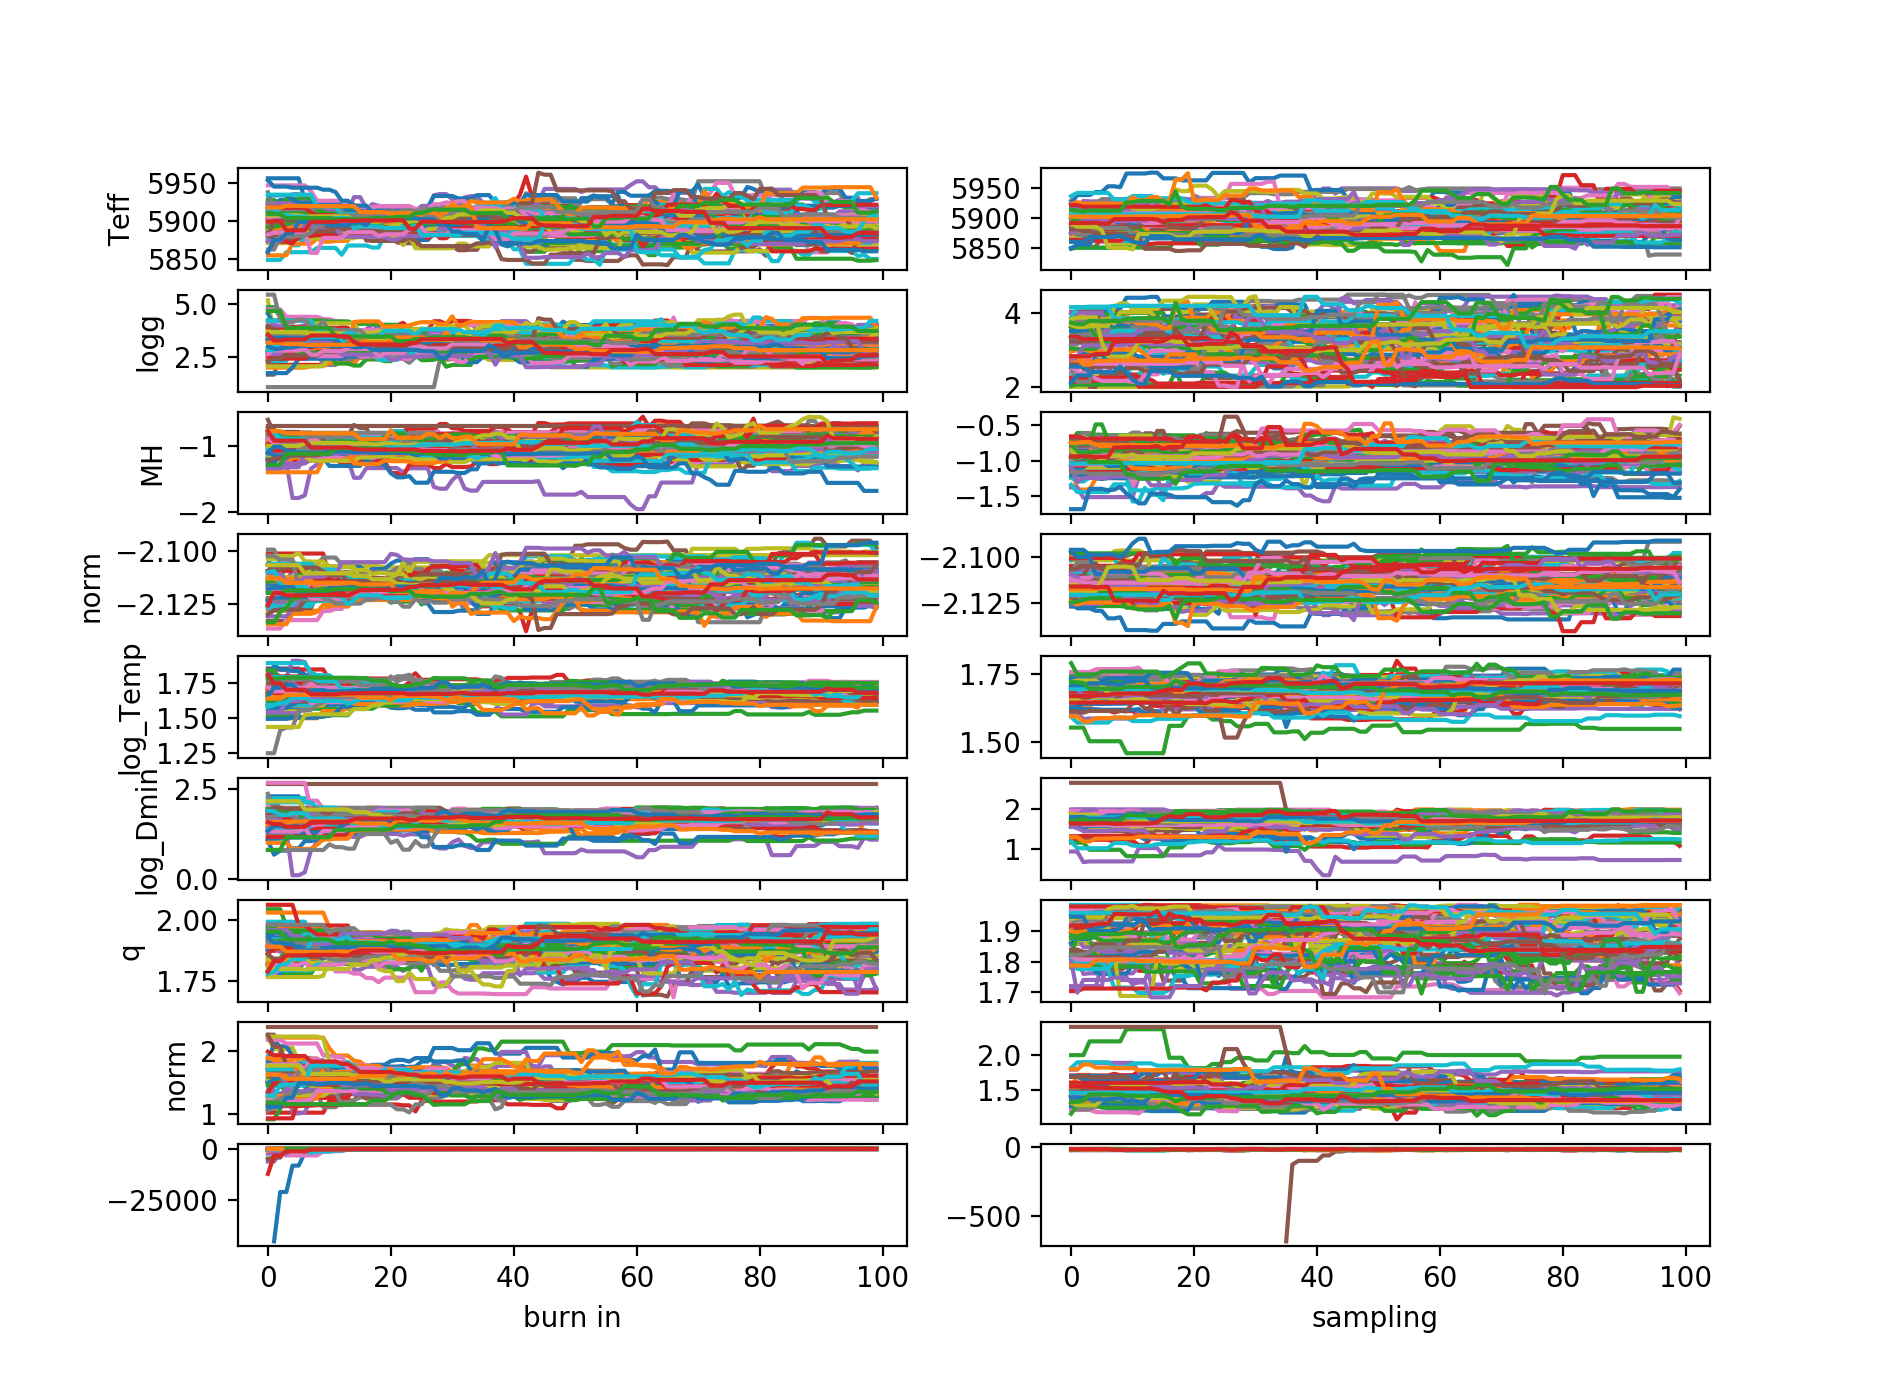

Text(0.5,0,'sampling')

In [5]:
# see what the chains look like, skip a burn in period if desired
burn = 100
fig,ax = plt.subplots(r.model_info['ndim']+1,2,figsize=(9.5,7),sharex='col',sharey=False)

for j in range(sampler.chain.shape[0]):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(r.model_info['ndim']):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(r.model_info['parameters'][i])

for j in range(sampler.chain.shape[0]):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(r.model_info['ndim']):
        ax[i,1].plot(sampler.chain[j,burn:,i])
#         ax[i,1].set_ylabel(ii.params[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')

<IPython.core.display.Javascript object>


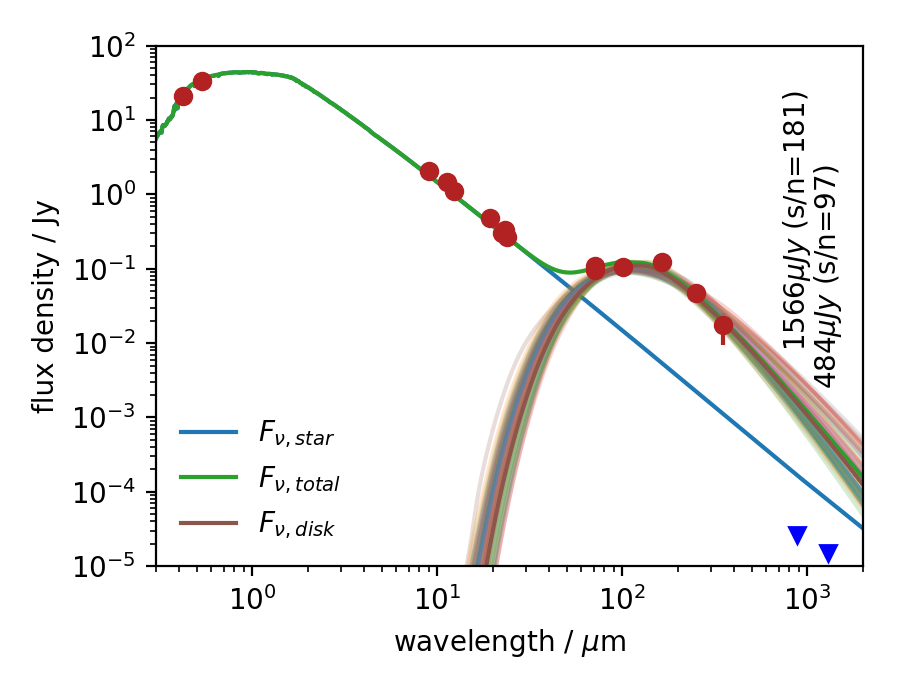

In [6]:
# make the plot
fig,ax = plt.subplots(figsize=(4.5,3.5))

# stellar and total spectra
ax.loglog(r.comp_spectra[0].wavelength,r.comp_spectra[0].fnujy,label='$F_{\\nu,star}$')

# disk
for i in range(sampler.chain.shape[0]):
    ax.plot(r.pl_models[1][1].wavelength,
            r.pl_models[1][1].fnujy(sampler.chain[i,-1,4:8]),
            alpha=0.2)

ax.loglog(r.total_spec.wavelength,r.total_spec.fnujy,color='C2',label='$F_{\\nu,total}$')
ax.plot(r.comp_spectra[1].wavelength,r.comp_spectra[1].fnujy,label='$F_{\\nu,disk}$')

# photometry
for p in r.obs:
    if not isinstance(p,sdf.photometry.Photometry):
        continue

    ok = np.invert(np.logical_or(p.upperlim,p.ignore))
    for i,f in enumerate(p.filters):
        if sdf.filter.iscolour(f) or f == 'SPIRE500' or f[:2] == '2M':
            ok[i] = False

    ax.errorbar(p.mean_wavelength()[ok],p.fnujy[ok],yerr=p.e_fnujy[ok],
                fmt='o',color='firebrick')
#     ax.plot(p.mean_wavelength()[p.upperlim],p.fnujy[p.upperlim],'v',color='firebrick')

# 3sigma ah ALMA sensitivity
b7_sens = 26e-6
b6_sens = 15e-6

# comparison of disk with ALMA sens
f1p3 = np.interp(1300, np.flipud(r.comp_spectra[1].wavelength), np.flipud(r.comp_spectra[1].fnujy))
ax.text(1300, f1p3*5, '{:3.0f}$\\mu Jy$ (s/n={:1.0f})'.format(f1p3*1e6, f1p3/b6_sens*3),
        rotation=90, va='bottom', ha='center')
f880 = np.interp(880, np.flipud(r.comp_spectra[1].wavelength), np.flipud(r.comp_spectra[1].fnujy))
ax.text(880, f880*5, '{:3.0f}$\\mu Jy$ (s/n={:1.0f})'.format(f880*1e6, f880/b7_sens*3),
        rotation=90, va='bottom', ha='center')
    
# ALMA
ax.plot(880, b7_sens, 'vb')
ax.plot(1.3e3, b6_sens, 'vb')
    
# annotation
ax.set_ylim(1e-5,100)
ax.set_xlim(0.3,2e3)
ax.set_ylabel('flux density / Jy')
ax.set_xlabel('wavelength / $\mu$m')

ax.legend(frameon=False, loc=3)

fig.tight_layout()
fig.savefig('sed_disk_uncertainty.pdf')